In [1]:
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

raw_data = load_files(r'C:\Users\Mrinal Jain\Human-Activity-Recognition\Data', random_state=17)
files = raw_data['filenames']
targets = raw_data['target']

train_files, test_files, train_targets, test_targets = train_test_split(files, targets, test_size=0.25, random_state=17)

In [2]:
import numpy as np
from utils import read_videos, one_hot_encode

X_train = read_videos(train_files[:200], target_size=(128, 128), max_frames=8, 
                      single_fps=True, normalize_pixels=True)
y_train = one_hot_encode(train_targets[:200], num_classes=6)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)

X_test = read_videos(test_files[:100], target_size=(128, 128), max_frames=8, 
                     single_fps=True, normalize_pixels=True)
y_test = one_hot_encode(test_targets[:100], num_classes=6)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)

Using TensorFlow backend.
100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:59<00:00,  1.12it/s]


Shape of training data: (200, 8, 128, 128, 1)
Shape of training labels: (200, 6)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26it/s]


Shape of testing data: (100, 8, 128, 128, 1)
Shape of testing labels: (100, 6)


In [13]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense, Dropout

model = Sequential()

model.add(Conv3D(filters=16, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal', input_shape=X_train.shape[1:]))
model.add(Conv3D(filters=32, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='same'))

model.add(Conv3D(filters=64, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(Conv3D(filters=128, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='same'))

model.add(Conv3D(filters=256, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(Conv3D(filters=512, kernel_size=3, strides=1, padding='same', 
                 activation='relu', kernel_initializer='he_normal'))
model.add(MaxPooling3D(pool_size=2, strides=2, padding='same'))

model.add(GlobalAveragePooling3D())
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 8, 128, 128, 16)   448       
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 8, 128, 128, 32)   13856     
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 4, 64, 64, 32)     0         
_________________________________________________________________
conv3d_32 (Conv3D)           (None, 4, 64, 64, 64)     55360     
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 4, 64, 64, 128)    221312    
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 2, 32, 32, 128)    0         
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 2, 32, 32, 256)    884992    
__________

In [14]:
from keras.callbacks import ModelCheckpoint

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='CNN.weights.best.hdf5', save_best_only=True, verbose=1)
history = model.fit(X_train, y_train, batch_size=2, epochs=5, validation_split=0.2, 
                    shuffle=True, verbose=2, callbacks=[checkpoint])

Train on 160 samples, validate on 40 samples
Epoch 1/5
Epoch 00001: val_loss improved from inf to 1.79987, saving model to CNN.weights.best.hdf5
 - 69s - loss: 1.9936 - acc: 0.1812 - val_loss: 1.7999 - val_acc: 0.1000
Epoch 2/5
Epoch 00002: val_loss improved from 1.79987 to 1.79860, saving model to CNN.weights.best.hdf5
 - 65s - loss: 1.7848 - acc: 0.2125 - val_loss: 1.7986 - val_acc: 0.1750
Epoch 3/5
Epoch 00003: val_loss did not improve
 - 64s - loss: 1.7898 - acc: 0.2250 - val_loss: 1.8043 - val_acc: 0.2000
Epoch 4/5
Epoch 00004: val_loss did not improve
 - 64s - loss: 1.7871 - acc: 0.2188 - val_loss: 1.8118 - val_acc: 0.2000
Epoch 5/5
Epoch 00005: val_loss did not improve
 - 64s - loss: 1.8182 - acc: 0.2063 - val_loss: 1.8077 - val_acc: 0.1000


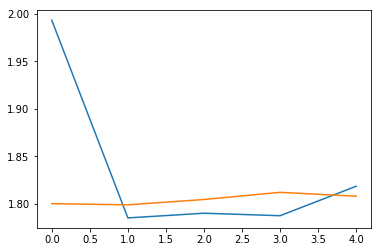

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(5)
plt.plot(epochs, loss, epochs, val_loss)

In [16]:
model.load_weights('CNN.weights.best.hdf5')
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=2, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 20.00%
